### **MODEL PREDIKTIF MENGGUNAKAN REGRESI DAN MEMBUAT CLUSTER**
**By : Putri Aulia**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#input data
customer = pd.read_csv('Case Study - Customer.csv', sep=';')
product = pd.read_csv('Case Study - Product.csv', sep=';')
store = pd.read_csv('Case Study - Store.csv', sep=';')
transaction = pd.read_csv('Case Study - Transaction.csv', sep=';')

In [ ]:
# cek apakah terdapat nilai Null/NaN
customer.isna().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [ ]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [ ]:
#mengisi missing value Marital Status dengan modus dari dataset
modus=customer['Marital Status'].mode()[0]
customer['Marital Status']=customer['Marital Status'].fillna(modus)
customer.isna().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
dtype: int64

In [ ]:
#mengubah tipe data yang tidak sesuai
customer['Income'] = customer['Income'].replace('[,]','.',regex=True).astype(float)

In [ ]:
product.isna().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

In [ ]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [ ]:
store.isna().sum()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64

In [ ]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [ ]:
store['Longitude'] = store['Longitude'].replace('[,]','.',regex=True).astype(float)
store['Latitude'] = store['Latitude'].replace('[,]','.',regex=True).astype(float)

In [ ]:
transaction.isna().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [ ]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [ ]:
transaction['Date'] = pd.to_datetime(transaction['Date'])

**Menggabungkan semua data**

In [ ]:
df_merge = pd.merge(transaction, customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, store, on=['StoreID'])
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554



### **TASK 3 - Machine Learning Regression (Time Series)**

In [ ]:
df_regresi = df_merge.groupby('Date').agg({'Qty':'sum'})
df_regresi

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


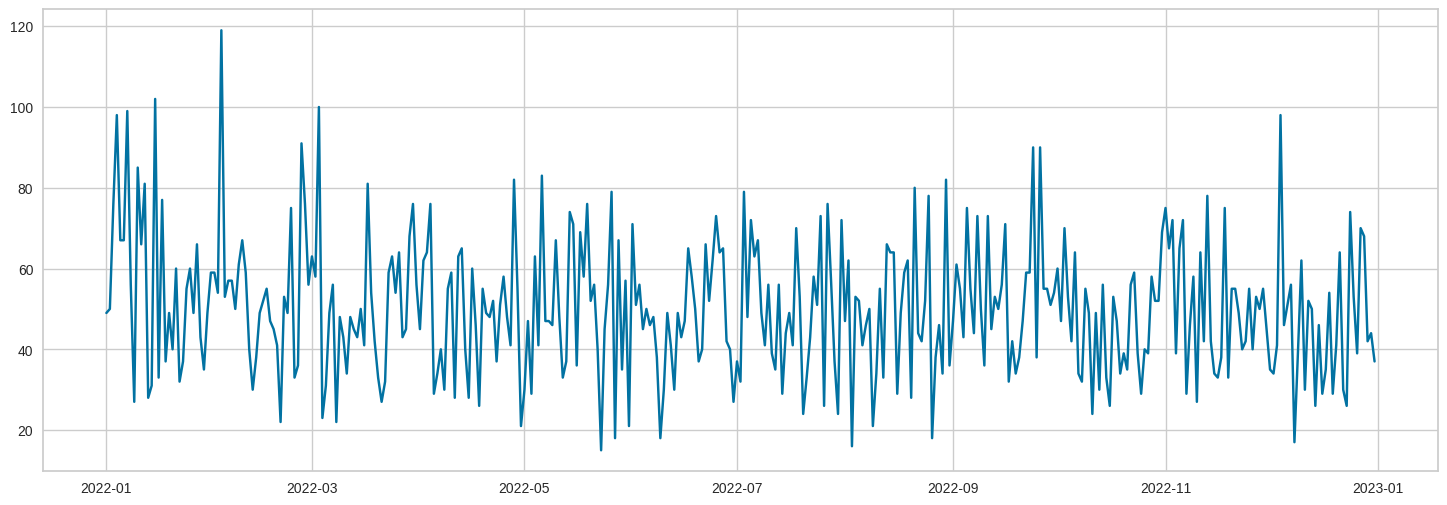

In [ ]:
# Visualize Data Quantity
plt.figure(figsize=[18,6])
plt.plot(df_regresi)
plt.show()

**Uji Data Stationer**

Stationer apabila suatu data runtut waktu memiliki rata-rata dan memiliki kecenderungan bergerak menuju rata-rata. Untuk melakukan analisis time series, data yang digunakan harus stationer. Uji yang digunakan adalah Uji Stasioneritas Augmented Dickey-Fuller (ADF).

Hipotesis uji stasioner ADF adalah:

H0 : data tidak stasioner

H1 : data stasioner

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_regresi)
print("1. ADF Statistic : ",result[0])
print("2. p-Value : ", result[1])
print("3. Critical Values :")
for key, val in result[4].items():
  print("\t",key, ": ", val)

1. ADF Statistic :  -19.018782802299725
2. p-Value :  0.0
3. Critical Values :
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


**p-value < 0.05 maka tolak H0, artinya data merupakan data stationer**

In [ ]:
# Bagi data menjadi data train dan data test
cut = round(df_regresi.shape[0]*0.8)
df_train = df_regresi[:cut]
df_test = df_regresi[cut:]
df_train.shape, df_test.shape

((292, 1), (73, 1))

In [ ]:
df_train

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-10-15,33
2022-10-16,26
2022-10-17,53


In [ ]:
df_test

,Qty
Date,
2022-10-20,39
2022-10-21,35
2022-10-22,56
2022-10-23,59
2022-10-24,39
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


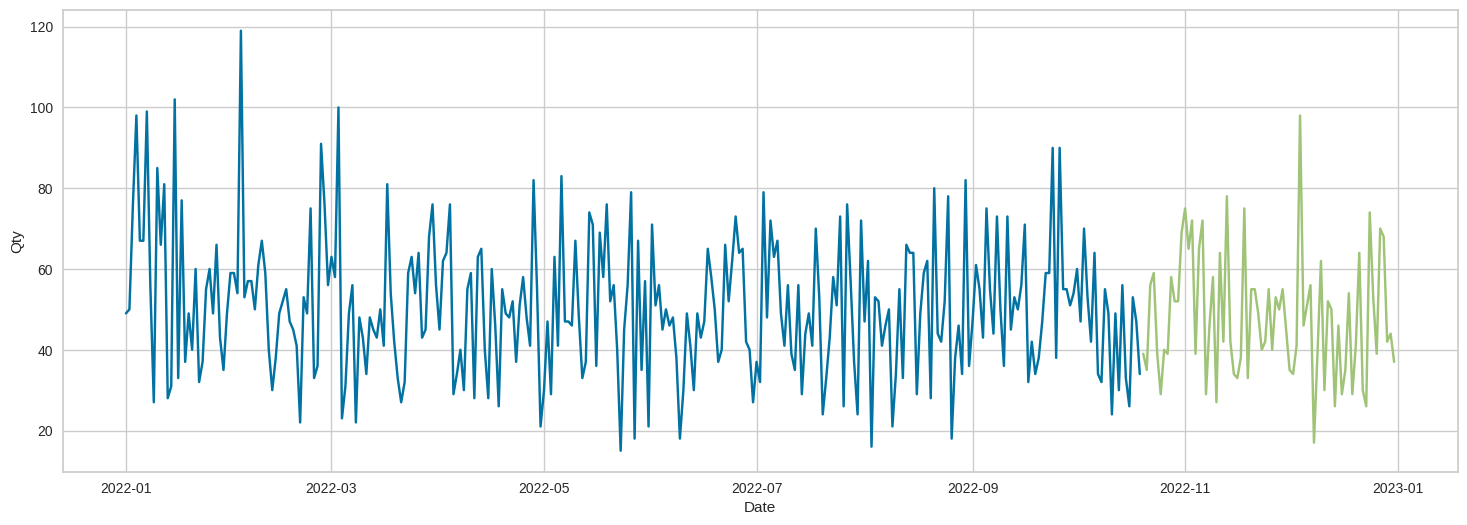

In [ ]:
plt.figure(figsize=(18,6))
sns.lineplot(data=df_train, x=df_train.index, y=df_train['Qty']);
sns.lineplot(data=df_test, x=df_test.index, y=df_test['Qty']);

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

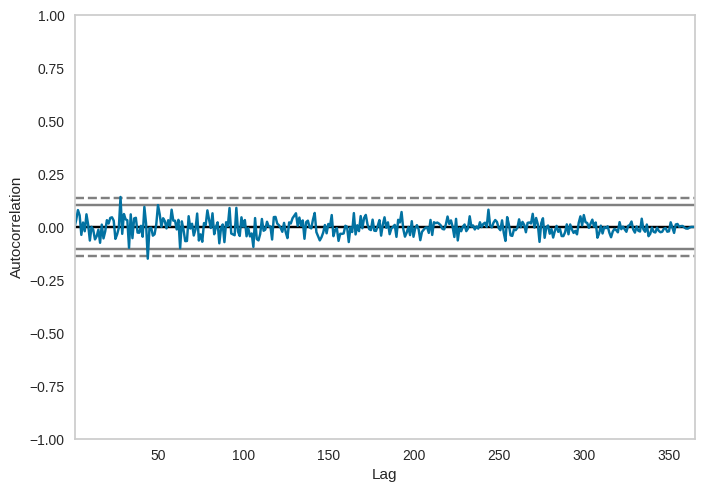

In [ ]:
pd.plotting.autocorrelation_plot(df_regresi['Qty'])

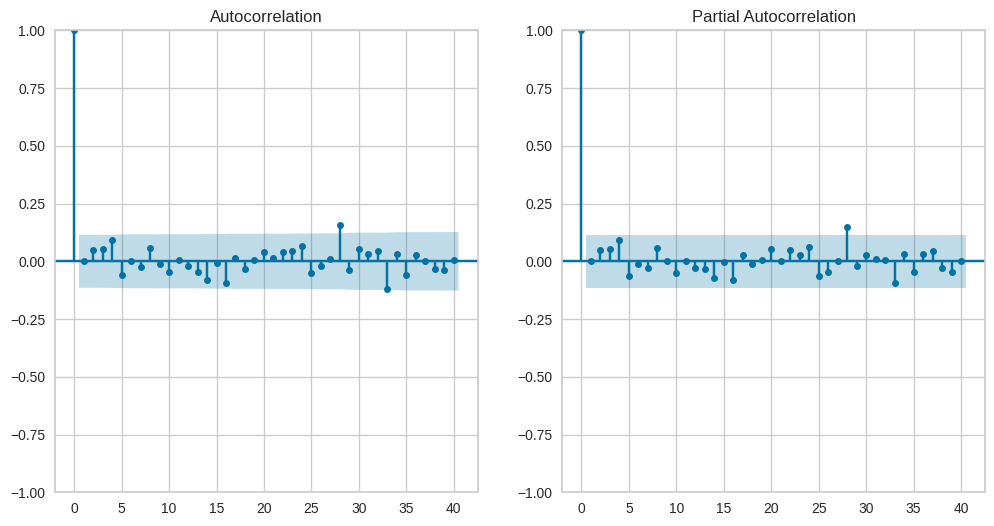

In [ ]:
# plot ACF and PACF untuk menentukan nilai p dan q
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(df_train, lags=40, ax=ax[0])
plot_pacf(df_train, lags=40, ax=ax[1])
plt.show()

In [ ]:
model = ARIMA(df_train, order=(28,0,28))
model_fit =model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  292
Model:               ARIMA(28, 0, 28)   Log Likelihood               -1210.274
Date:                Sun, 01 Oct 2023   AIC                           2536.549
Time:                        07:44:22   BIC                           2749.800
Sample:                    01-01-2022   HQIC                          2621.969
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.6849      3.009     16.842      0.000      44.786      56.583
ar.L1          0.1138      0.494      0.230      0.818      -0.855       1.083
ar.L2          0.3573      0.510      0.701      0.4

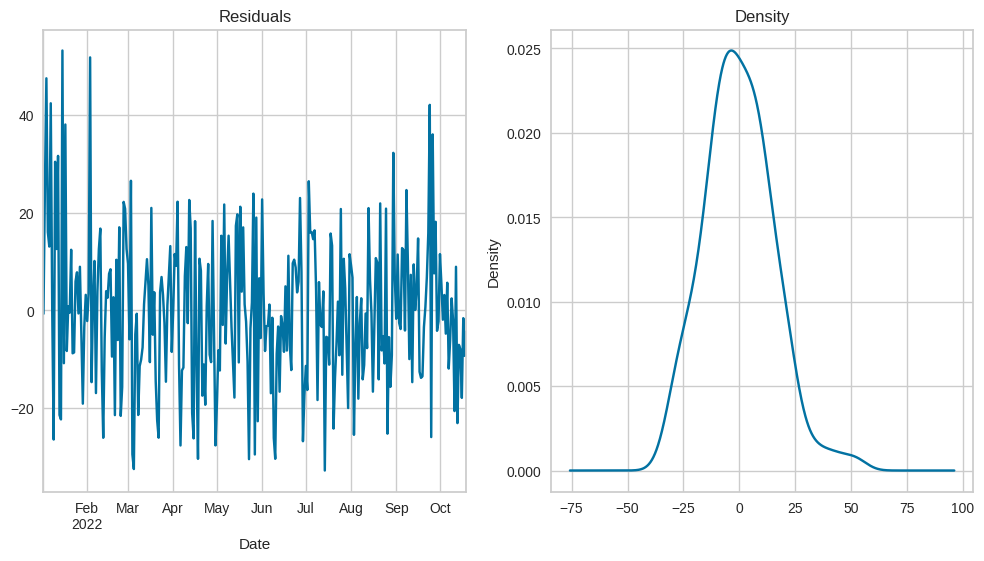

In [ ]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(12, 6))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

<Axes: xlabel='Date'>

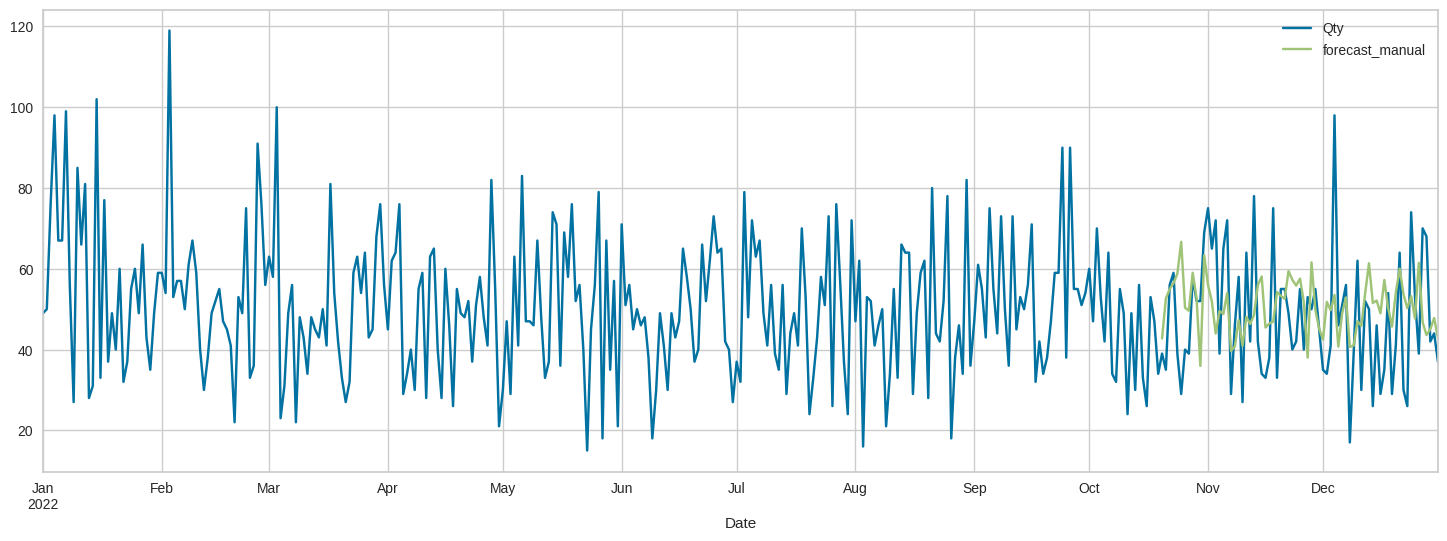

In [ ]:
forecast_manual = model_fit.forecast(len(df_test))
df_regresitest = df_regresi
df_regresitest['forecast_manual'] = [None]*len(df_train) + list(forecast_manual)
df_regresitest.plot(figsize=(18,6))

In [ ]:
mae = mean_absolute_error(df_test, forecast_manual)
mape = mean_absolute_percentage_error(df_test, forecast_manual)
rmse = np.sqrt(mean_squared_error(df_test, forecast_manual))

print(f'mae - manual: {round(mae,4)}')
print(f'mape - manual: {round(mape,4)}')
print(f'rmse - manual: {round(rmse,4)}')

mae - manual: 12.9993
mape - manual: 0.313
rmse - manual: 15.9846


**Interpretasi:**

Nilai MAPE < 10% : Kemampuan peramalan sangat baik

In [ ]:
model = ARIMA(df_regresi['Qty'], order=(28, 0, 28))
model_fit = model.fit()
forecast = model_fit.forecast(steps=31)
forecast

2023-01-01    56.660941
2023-01-02    54.228365
2023-01-03    55.916573
2023-01-04    58.518357
2023-01-05    39.152558
2023-01-06    40.601883
2023-01-07    53.284977
2023-01-08    40.732235
2023-01-09    49.249555
2023-01-10    57.292956
2023-01-11    39.980634
2023-01-12    44.583838
2023-01-13    53.875423
2023-01-14    51.220816
2023-01-15    46.216068
2023-01-16    46.884097
2023-01-17    49.366018
2023-01-18    51.375114
2023-01-19    34.399286
2023-01-20    41.985759
2023-01-21    65.377828
2023-01-22    49.669708
2023-01-23    44.160293
2023-01-24    60.655176
2023-01-25    52.237133
2023-01-26    45.606550
2023-01-27    48.163335
2023-01-28    44.187630
2023-01-29    53.764175
2023-01-30    47.310814
2023-01-31    52.688658
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
forecast.describe()

count    31.000000
mean     49.333766
std       6.992752
min      34.399286
25%      44.385734
50%      49.366018
75%      53.819799
max      65.377828
Name: predicted_mean, dtype: float64

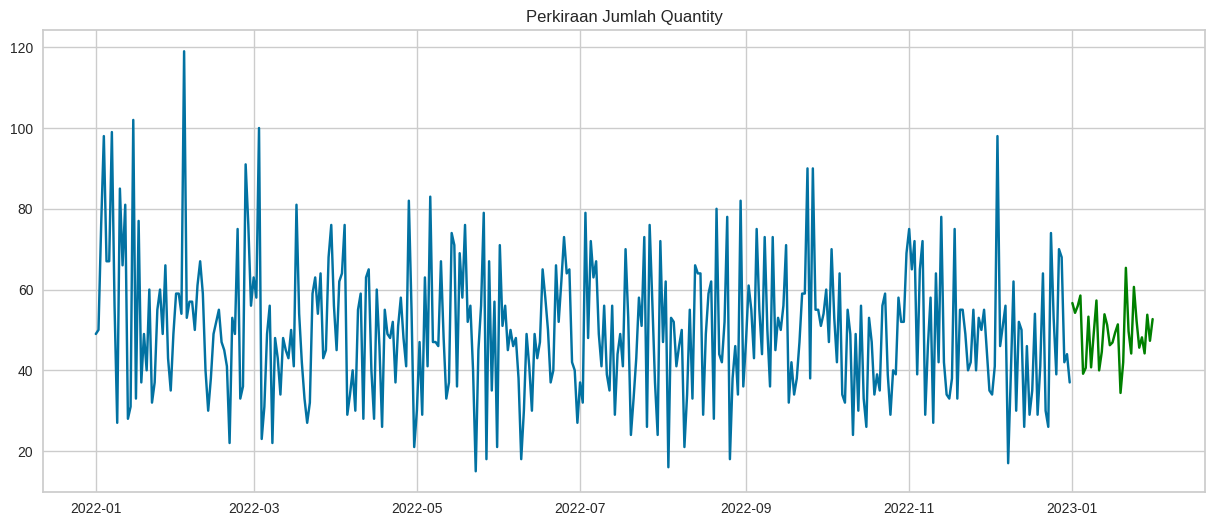

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_merge.groupby('Date').agg({'Qty':'sum'}))
plt.plot(forecast,color='green')
plt.title('Perkiraan Jumlah Quantity')
plt.show()

### **TASK 3 - Machine Learning Clustering**

In [ ]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [ ]:
#identifikasi variabel yang memiliki korelasi tinggi
df_merge.corr()

,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.016423,-0.009755,-0.024915,0.004129,-0.025952,-0.009947,0.005783,0.002278,-0.003122
Price,-0.016423,1.000000,-0.353640,0.440632,-0.032863,0.014693,0.010705,0.001196,-0.029008,0.018652
Qty,-0.009755,-0.353640,1.000000,0.621129,0.014365,-0.027768,-0.010542,-0.028425,-0.004170,0.004807
TotalAmount,-0.024915,0.440632,0.621129,1.000000,-0.010722,-0.016900,-0.008774,-0.025350,-0.029938,0.025437
StoreID,0.004129,-0.032863,0.014365,-0.010722,1.000000,-0.003872,-0.000189,0.001613,0.471852,-0.094943
Age,-0.025952,0.014693,-0.027768,-0.016900,-0.003872,1.000000,-0.033183,0.486692,0.009266,0.015951
Gender,-0.009947,0.010705,-0.010542,-0.008774,-0.000189,-0.033183,1.000000,-0.071443,-0.006051,-0.001183
Income,0.005783,0.001196,-0.028425,-0.025350,0.001613,0.486692,-0.071443,1.000000,0.015518,0.004385
Latitude,0.002278,-0.029008,-0.004170,-0.029938,0.471852,0.009266,-0.006051,0.015518,1.000000,-0.395995
Longitude,-0.003122,0.018652,0.004807,0.025437,-0.094943,0.015951,-0.001183,0.004385,-0.395995,1.000000


In [ ]:
df_cluster = df_merge.groupby('CustomerID').agg({'TransactionID' : 'count',
                                                   'Qty' : 'sum',
                                                   'TotalAmount' : 'sum'
}).reset_index()

In [ ]:
df_cluster

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [ ]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   CustomerID     447 non-null    int64
 1   TransactionID  447 non-null    int64
 2   Qty            447 non-null    int64
 3   TotalAmount    447 non-null    int64
dtypes: int64(4)
memory usage: 14.1 KB


In [ ]:
df_cluster1 = df_cluster.drop(columns = ['CustomerID'])
df_cluster1

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600
...,...,...,...
442,16,59,485100
443,18,62,577700
444,18,68,587200
445,11,42,423300


In [ ]:
# Normalisasi data
df_cluster_normal = preprocessing.normalize(df_cluster1)

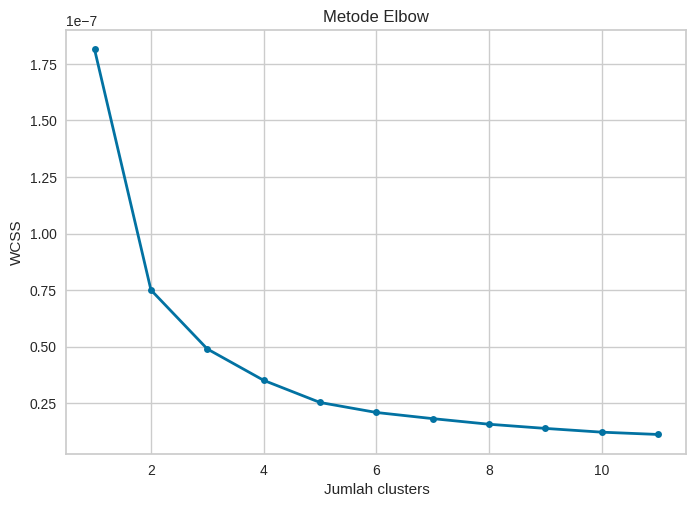

In [ ]:
# Menggunakan metode elbow untuk menentukan angka cluster yang tepat
wcss = []
for i in range(1,12):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 100)
    kmeans.fit(df_cluster_normal)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,12), wcss, marker = 'o', linewidth=2, markersize=5)
plt.title('Metode Elbow')
plt.xlabel('Jumlah clusters')
plt.ylabel('WCSS')
plt.show()

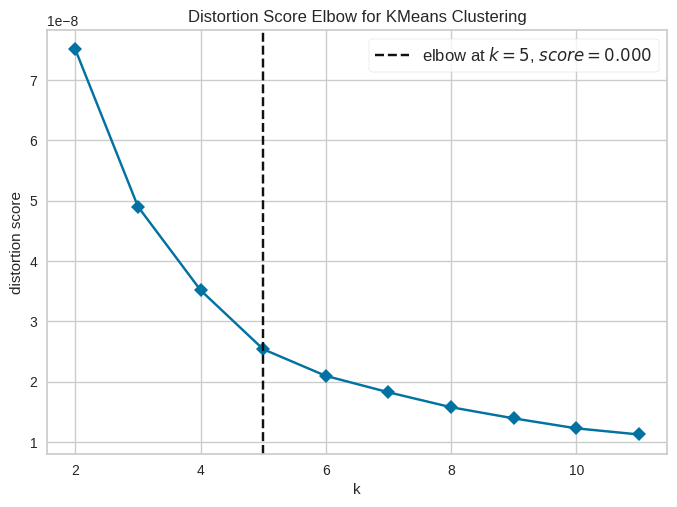

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
visualizer = KElbowVisualizer(kmeans, k=(2,12), timings=False)
visualizer.fit(df_cluster_normal)
visualizer.show()

<Axes: >

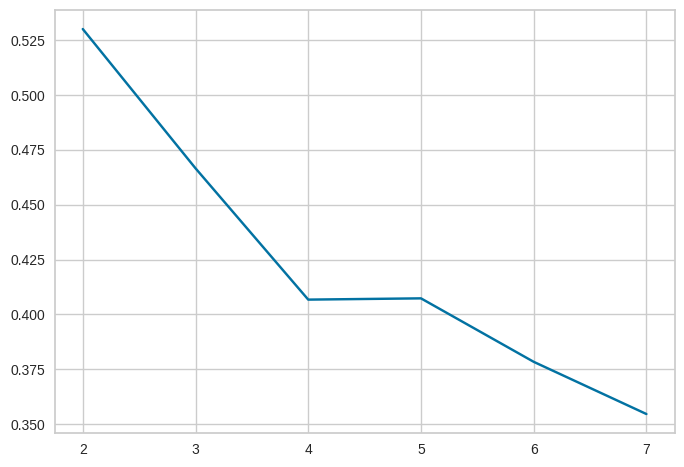

In [ ]:
K = range(2,8)
fits = []
score = []

for k in K:
    model = KMeans(n_clusters = k, random_state = 0, n_init= 'auto').fit(df_cluster_normal)
    fits.append(model)
    score.append(silhouette_score(df_cluster_normal, model.labels_, metric='euclidean'))

sns.lineplot(x = K, y = score)

In [ ]:
# Menjalankan K-Means Clustering ke dataset
# jumlah klaster = 5
kmeans = KMeans(n_clusters = 5, random_state = 100)
kmeans.fit_predict(df_cluster)

array([1, 0, 3, 2, 2, 3, 3, 3, 0, 3, 2, 1, 1, 0, 0, 0, 0, 3, 1, 3, 2, 0,
       3, 0, 4, 4, 2, 2, 3, 2, 0, 0, 4, 3, 2, 2, 1, 2, 0, 2, 4, 0, 3, 3,
       1, 3, 1, 0, 2, 4, 3, 2, 0, 0, 2, 4, 0, 0, 4, 0, 2, 3, 1, 2, 4, 0,
       3, 2, 0, 2, 2, 1, 3, 4, 0, 3, 0, 2, 4, 2, 2, 0, 0, 3, 0, 2, 0, 1,
       1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 3, 0, 2, 4, 3, 1, 3, 0, 2, 4,
       4, 3, 4, 3, 3, 0, 2, 3, 0, 3, 3, 2, 2, 3, 4, 4, 3, 2, 0, 2, 3, 3,
       3, 0, 0, 2, 3, 0, 2, 2, 0, 0, 2, 2, 4, 4, 0, 4, 0, 3, 0, 3, 4, 2,
       0, 1, 1, 3, 2, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 4, 1, 3, 0, 3, 2, 2,
       0, 0, 4, 4, 2, 2, 2, 1, 4, 0, 3, 2, 1, 0, 0, 4, 2, 4, 0, 2, 2, 0,
       3, 4, 0, 2, 0, 0, 2, 0, 2, 4, 0, 1, 2, 2, 0, 2, 0, 2, 3, 0, 3, 2,
       0, 3, 0, 2, 2, 0, 4, 2, 0, 2, 3, 0, 1, 3, 3, 0, 3, 2, 0, 3, 2, 4,
       3, 0, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 4, 0, 0, 2, 4, 1, 4, 4, 1, 3,
       4, 2, 0, 0, 0, 3, 2, 3, 0, 2, 2, 3, 1, 0, 0, 0, 3, 3, 3, 0, 2, 4,
       2, 0, 0, 4, 4, 4, 2, 2, 0, 2, 2, 0, 1, 4, 1,

In [ ]:
# Memasukkan cluster ke dalam dataset
df_cluster['cluster'] = kmeans.labels_
df_cluster

,CustomerID,TransactionID,Qty,TotalAmount,cluster
0,1,17,60,623300,1
1,2,13,57,392300,0
2,3,15,56,446200,3
3,4,10,46,302500,2
4,5,7,27,268600,2
...,...,...,...,...,...
442,443,16,59,485100,3
443,444,18,62,577700,1
444,445,18,68,587200,1
445,446,11,42,423300,0


<Figure size 600x600 with 0 Axes>

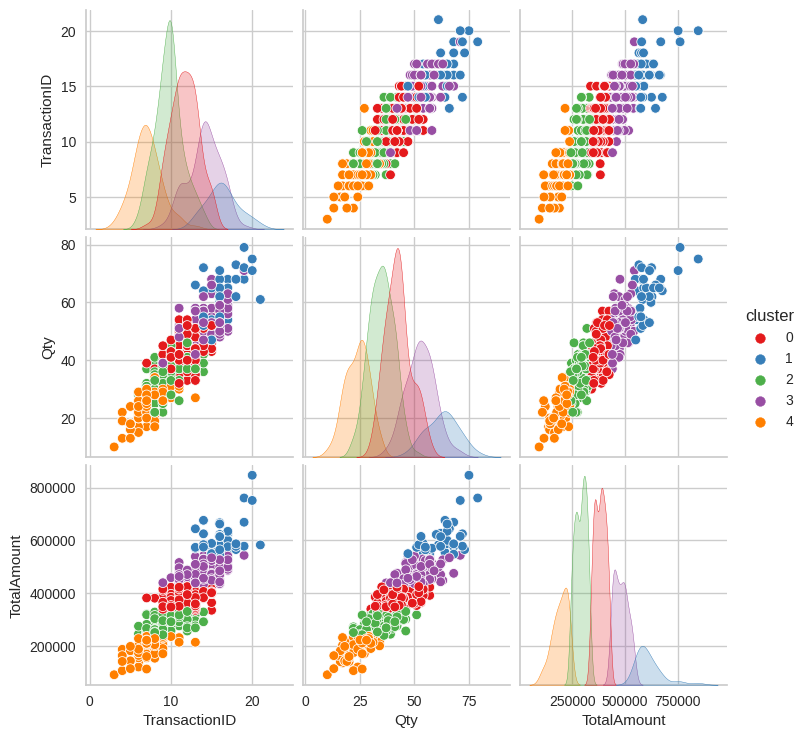

In [ ]:
# Visualisasi hasil clusters
plt.figure(figsize=(6,6))
sns.pairplot(data=df_cluster1, palette='Set1', hue='cluster')
plt.show()

In [ ]:
df_cluster.groupby(['cluster']).agg({'CustomerID' : 'count',
                                      'TransactionID' : 'mean',
                                      'Qty' : 'mean',
                                      'TotalAmount' : 'mean'})

,CustomerID,TransactionID,Qty,TotalAmount
cluster,,,,
0,124,11.661290,42.508065,381419.354839
1,38,16.342105,62.815789,611818.421053
2,127,9.748031,34.842520,288907.086614
3,85,14.105882,52.717647,480628.235294
4,73,7.068493,23.726027,191141.095890
